In [1]:
import os 
os.environ["CUDA_VISIBLE_DEVICES"] = "2" # put -1 to not use any

import sys
sys.path.append('/home/lumargot/hysterectomy-coach/src/py')


In [2]:
import torch
import torch
import SimpleITK as sitk
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm

from torch.utils.data import Dataset, DataLoader
from torchvision.ops import masks_to_boxes
from torchvision.utils import draw_segmentation_masks
from torchvision.transforms.functional import to_pil_image, pil_to_tensor
import matplotlib.pyplot as plt


from nets.segmentation import  Mask2Former
from loaders.hyst_dataset import BBXImageEvalTransform,BBXImageTrainTransform,BBXImageTestTransform, HystDataModuleFormer
# from utils import 

/home/lumargot/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
A new version of Albumentations is available: '2.0.7' (you have '2.0.3'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.


In [3]:
concats = ['Bipolar', 'Vessel Sealer', 'Robot Grasper Heat', 'Scissors', 'Suction', 'Robot Scissors', 'monopolarhook' ]


def construct_class_mapping(df_labels, class_column, label_column):
    df_labels = df_labels.loc[df_labels[label_column] != 'Needle']
    df_labels.loc[ df_labels[label_column].isin(concats), label_column ] = 'Others'

    unique_classes = sorted(df_labels[label_column].unique())
    class_mapping = {value: idx+1 for idx, value in enumerate(unique_classes)}
    return class_mapping

def remove_labels(df, class_mapping, class_column, label_column):

    df = df.loc[df['to_drop'] == 0]
    
    df = df.loc[df[label_column] != 'Needle']
    df.loc[ df[label_column].isin(concats), label_column ] = 'Others'

    df[class_column] = df[label_column].map(class_mapping)

    print(f"{df[[label_column, class_column]].drop_duplicates()}")
    return df.reset_index()

In [4]:
df_train = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_train.csv')
df_val = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_train_test.csv')
df_test = pd.read_csv('/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/csv/dataset_test.csv')

df_labels = pd.concat([df_train, df_val, df_test])

img_column = 'img_path'
seg_column = 'seg_path'
class_column = 'simplified_class'
label_column = 'simplified_label'
mnt = '/CMF/data/lumargot/hysterectomy/mnt/surgery_tracking/'

class_mapping = construct_class_mapping(df_labels, class_column, label_column)

df_test = remove_labels(df_test, class_mapping, class_column, label_column)
df_train = remove_labels(df_train, class_mapping, class_column, label_column)
df_val = remove_labels(df_val, class_mapping, class_column, label_column)


unique_classes = np.sort(np.unique(df_train['class']))
out_features = len(unique_classes)+1 # background

ttdata = HystDataModuleFormer( df_train, df_val, df_test, batch_size=1, num_workers=4, 
                            img_column=img_column,seg_column=seg_column, class_column=class_column, 
                            mount_point=mnt,train_transform=BBXImageTrainTransform(),
                            valid_transform=BBXImageEvalTransform(), test_transform=BBXImageTestTransform())

ttdata.setup()
test_dl = ttdata.test_dataloader()

     simplified_label  simplified_class
0             Grasper                 1
1       Needle Driver                 2
1117           Others                 3
   simplified_label  simplified_class
0           Grasper                 1
2     Needle Driver                 2
87           Others                 3
     simplified_label  simplified_class
0       Needle Driver                 2
1             Grasper                 1
1982           Others                 3


### Train

In [14]:
ds = ttdata.test_ds
ds[0]

{'pixel_values': tensor([[[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          ...,
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

         [[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0059, 0.0059, 0.0059],
          [0.0000, 0.0000

In [5]:
# Create model
ckpt = '/CMF/data/lumargot/hysterectomy/out/mask2former/epoch=17-val_loss=40.57.ckpt'
model = Mask2Former.load_from_checkpoint(ckpt)
model.cuda()
model.eval()

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-base-coco-instance and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([81]) in the checkpoint and torch.Size([5]) in the model instantiated
- class_predictor.weight: found shape torch.Size([81, 256]) in the checkpoint and torch.Size([5, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([81]) in the checkpoint and torch.Size([5]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Mask2Former(
  (model): Mask2FormerForUniversalSegmentation(
    (model): Mask2FormerModel(
      (pixel_level_module): Mask2FormerPixelLevelModule(
        (encoder): SwinBackbone(
          (embeddings): SwinEmbeddings(
            (patch_embeddings): SwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): SwinEncoder(
            (layers): ModuleList(
              (0): SwinStage(
                (blocks): ModuleList(
                  (0-1): 2 x SwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): SwinAttention(
                      (self): SwinSelfAttention(
                        (query): Linear(in_features=128, out_features=128, bias=True)
                        (key): Linear(in_

In [28]:
from torchvision.ops import nms
from sklearn.metrics import classification_report, confusion_matrix

from utils import *
from visualization import *
from evaluation import *

In [ ]:
y_true = []
y_pred = []
stats = defaultdict(list)

for idx, batch in tqdm(enumerate(test_dl)):
  for k,v in batch.items():
    if isinstance(batch[k], list) :
      batch[k] = [ elt.cuda() for elt in batch[k]] 
    else:
      batch[k] = batch[k].cuda()

  SCORE_THR = 0.5
  gt_masks = batch['mask_labels'][0].cpu().detach()
  gt_labels = batch['class_labels'][0].cpu().detach()
  gt_boxes = boxes = torch.tensor(ds[idx]['boxes'])
  _, outs = model(batch)

  original_sizes = [(img.shape[1],img.shape[2]) for img in batch['pixel_values']]  

  # Post-process outputs
  result= model.processor.post_process_instance_segmentation( outs, target_sizes=original_sizes,)[0]

  multimask = result['segmentation']
  segments = result['segments_info']

  pred_masks = []
  pred_labels = []
  pred_scores = []
  if len(segments) > 0:
    for segment in segments:
      id, label, score = segment['id'], segment['label_id'], segment['score']
      binary_mask = (result['segmentation'] == id).unsqueeze(0).to(torch.float32)
      
      pred_masks.append(binary_mask)
      pred_labels.append(torch.tensor(label).unsqueeze(0))
      pred_scores.append(torch.tensor(score).unsqueeze(0))
      
    pred_masks = torch.cat(pred_masks)
    pred_labels = torch.cat(pred_labels)
    pred_scores = torch.cat(pred_scores)

    gt_dic = {'boxes':gt_boxes, 'labels':gt_labels, 'masks':gt_masks}
    pred_dic = {'scores':pred_scores, 'labels':pred_labels, 'masks': pred_masks}

    if (pred_scores >=SCORE_THR).any():
        
      keep = pred_scores >= SCORE_THR
      pred_dic=apply_indices_selection(pred_dic, keep)

      keep = remove_empty_predictions(pred_masks)
      pred_dic=apply_indices_selection(pred_dic, keep)
      pred_boxes = masks_to_boxes(pred_dic['masks'])

      pred_dic['boxes'] = pred_boxes

      nms_indices = nms(pred_dic['boxes'], pred_dic['scores'],0.3)
      pred_dic_filtered=apply_indices_selection(pred_dic, nms_indices)

      stats, gt_label, pred_label = get_prediction_metrics(gt_dic, pred_dic_filtered, stats, iou_threshold=0.25)
      y_true.append(torch.tensor(gt_label))
      y_pred.append(torch.tensor(pred_label))



0it [00:00, ?it/s]To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
To copy construct from a tensor, it is recommended to use sourceTen

ValueError: Unable to create tensor, you should probably activate padding with 'padding=True' to have batched tensors with the same length.

In [56]:
class_names = df_test['simplified_label'].unique()
class_names = list(class_mapping.keys())
y_true = torch.concat(y_true)
y_pred = torch.concat(y_pred)

In [54]:
def compute_global_metrics(classes, y_true, y_pred, stats, iou_threshold=0.5) :
    tp = sum(stats['total_tp'])
    fp = sum(stats['total_fp'])
    fn = sum(stats['total_fn'])

    mean_box_iou = np.array(stats['stats_box_iou'])
    mean_mask_iou = np.array(stats['stats_mask_iou'])
    mean_dice  = np.array(stats['stats_dice'])

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0

    # Compute AP per class (macro average)
    ap_per_class = {}
    for cls in classes:
        cls_id = classes.index(cls) +1
        y_true_bin = [1 if y == cls_id else 0 for y in y_true]
        y_pred_bin = [1 if y == cls_id else 0 for y in y_pred]
        if any(y_true_bin):  # Only compute AP if this class is present in GT
            ap = average_precision_score(y_true_bin, y_pred_bin)
        else:
            ap = float('nan')  # or 0.0
        ap_per_class[cls] = ap
    valid_aps = [ap for ap in ap_per_class.values() if not np.isnan(ap)]
    mean_ap = np.mean(valid_aps) if valid_aps else 0.0


    df_pred  = pd.DataFrame(data={'gt': y_true, 'pred': y_pred})
    data_stats = {f'precision@IoU>{iou_threshold}': precision,
                 'recall': recall,
                 'f1_score': f1,
                 'mean_box_iou': np.mean(mean_box_iou) ,
                 'mean_mask_iou': np.mean(mean_mask_iou) ,
                 'mean_dice': np.mean(mean_dice) ,
                 'false_positives': fp,
                 'false_negatives': fn,
                 'true_positives': tp,
                 'average_precision_per_class': ap_per_class,
                 'mean_average_precision': mean_ap,
                 'labels': classes,
                #  'pr_curve_data': {'scores': stats['scores'], 
                #                    'matches': (np.array(y_true) == np.array(y_pred)).astype(int).tolist() }
    }
    return df_pred, data_stats

In [57]:
df_pred, out_dict = compute_global_metrics(class_names, y_true, y_pred, stats, iou_threshold=0.5)

In [61]:
data_dir = os.path.splitext(ckpt)[0]

In [64]:
import json

In [65]:
if not os.path.exists(data_dir):
    os.mkdir(data_dir)
df_pred.to_csv(os.path.join(data_dir, 'prediction.csv'))
filename = os.path.join(data_dir, 'output_stats.json')
with open(filename, 'w') as file:
    json.dump(out_dict, file, indent=2)

In [66]:
report = classification_report(y_true, y_pred, output_dict=True)
print(report)

print(json.dumps(report, indent=2))
df_report = pd.DataFrame(report).transpose()
df_report.to_csv(os.path.join(data_dir, 'classification_report.csv'))

{'1.0': {'precision': 0.8583657587548638, 'recall': 0.6292070735881347, 'f1-score': 0.7261356155365372, 'support': 1753}, '2.0': {'precision': 0.06845238095238096, 'recall': 0.17100371747211895, 'f1-score': 0.09776833156216792, 'support': 269}, '3.0': {'precision': 0.05405405405405406, 'recall': 0.4444444444444444, 'f1-score': 0.0963855421686747, 'support': 9}, 'accuracy': 0.567700640078779, 'macro avg': {'precision': 0.32695739792043294, 'recall': 0.41488507850156603, 'f1-score': 0.3067631630891266, 'support': 2031}, 'weighted avg': {'precision': 0.7501798877695485, 'recall': 0.567700640078779, 'f1-score': 0.6401195889243185, 'support': 2031}}
{
  "1.0": {
    "precision": 0.8583657587548638,
    "recall": 0.6292070735881347,
    "f1-score": 0.7261356155365372,
    "support": 1753
  },
  "2.0": {
    "precision": 0.06845238095238096,
    "recall": 0.17100371747211895,
    "f1-score": 0.09776833156216792,
    "support": 269
  },
  "3.0": {
    "precision": 0.05405405405405406,
    "rec

Confusion matrix, without normalization
Normalized confusion matrix, avg: 0.41488507850156603


Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.


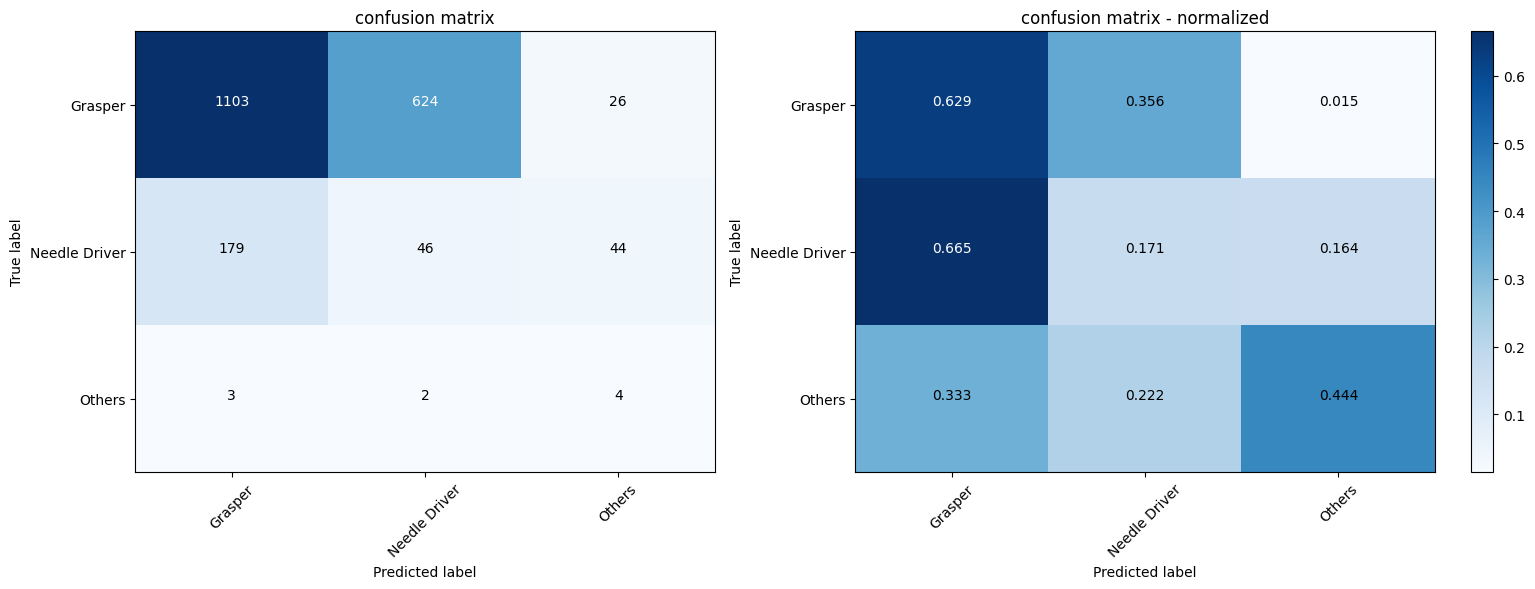

In [67]:
cnf_matrix = confusion_matrix(y_true, y_pred)
np.set_printoptions(precision=3)

# Plot non-normalized confusion matrix
fig = plt.figure(figsize=(16,6))

plt.subplot(121)
plot_confusion_matrix(cnf_matrix, classes=class_names, title='confusion matrix')

plt.subplot(122)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='confusion matrix - normalized')

plt.savefig(os.path.join(data_dir, 'confusion_matrix.png'))

In [44]:
def remove_empty_predictions(pred_masks):
  indices = []
  for idx in range(pred_masks.shape[0]):
    if pred_masks[idx].max() != 0:
      indices.append(idx)
  return indices

In [9]:
from torchvision.ops import masks_to_boxes, box_iou

[-1.  5.]
[-1.  4.  5.  6.]
[-1.  5.  6.]
[-1.  5.  6.]


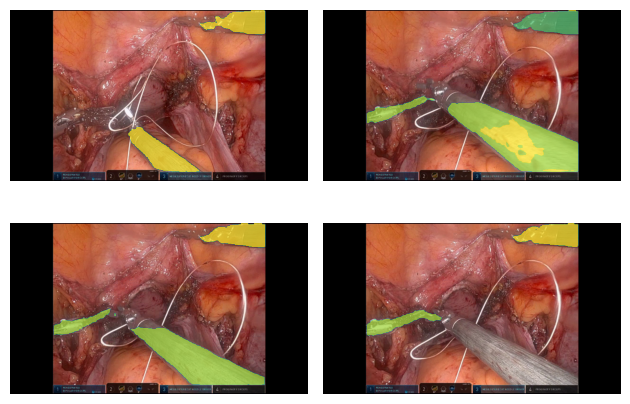

In [ ]:
n_cols= int(n_images /2)
fig, axs = plt.subplots(2, n_cols)
axs = axs.flatten()


for ax, image, result in zip(axs, all_images, results):
    multimask = result['segmentation']
    mask = np.zeros_like(multimask)
    segments = result['segments_info']
    pred_masks = []
    if len(segments) > 0:
        for segment in segments:
            id, label = segment['id'], segment['label_id']
            multimask[multimask==id] = label

    ax.imshow(image.permute(1,2,0).cpu().detach().numpy())
    ax.imshow(multimask,alpha=0.7*(multimask>0))
    ax.axis('off')  # Optional: Turn off axes for better visualization

ax.axis('off')  # Optional: Turn off axes for better visualization

plt.tight_layout()
plt.show()
plt.close()